# Extended Kalman Filter DSSE
The EKF method has two-steps i.e., prediction step and an update step. Note that the voltage magnitudes and voltage angles are the states to be estimated. Therefore, the number of states is twice as many compared to the total number of nodes in the system.

In [25]:
import os
import json
import math
from oedisi.types.data_types import MeasurementArray, AdmittanceMatrix, Topology
import pyarrow.feather as feather
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
ROOT = os.getcwd()
OUTPUTS = "outputs"

## Run OEDISI

In [12]:
SCENARIO_DIR, SCENARIOS, _ = next(os.walk(f'{ROOT}/scenario/'))

print(SCENARIO_DIR)
for idx, scenario in enumerate(SCENARIOS):
    print(idx, scenario)

/home/scenario/
0 ieee123


In [13]:
index = 0
SCENARIO = SCENARIOS[index]
path = f"{SCENARIO_DIR}{SCENARIO}"

In [14]:
os.system(f"oedisi build --system {path}/system.json --component-dict {path}/components.json --target-directory build_{SCENARIO}") 

Loading the components defined in /home/scenario/ieee123/components.json
Loading system json /home/scenario/ieee123/system.json
Building system in build_ieee123


0

In [70]:
os.system("pkill -9 helics_broker")
os.system(f"oedisi run --runner build_{SCENARIO}/system_runner.json")

[warn] helics-cli's web interface is not installed. You may want to run `pip install "helics[cli]"`.
[warn] helics-cli's observer functionality is not installed. You may want to run `pip install "helics[cli]"`.
[info] Running federation: wls_ieee123
[info] Running federate recorder_voltage_real as a background process
[info] Running federate recorder_voltage_imag as a background process
[info] Running federate recorder_voltage_mag as a background process
[info] Running federate recorder_voltage_angle as a background process
[info] Running federate pnnl_state_estimator as a background process
[info] Running federate local_feeder as a background process
[info] Running federate sensor_voltage_magnitude as a background process
[info] Running federate sensor_power_real as a background process
[info] Running federate sensor_power_imaginary as a background process
[info] Running federate broker as a background process
[info] Waiting for 10 processes to finish ...
[error] Process recorder_volt

0

## Load Outputs

In [42]:
directory = f"{OUTPUTS}/{SCENARIO}"
v_real = feather.read_feather(
    os.path.join(directory, "voltage_real.feather")
)
v_imag = feather.read_feather(
    os.path.join(directory, "voltage_imag.feather")
)
true_voltages = v_real.drop("time", axis=1) + 1j * v_imag.drop("time", axis=1)
true_voltages['time'] = pd.to_datetime(v_real['time'],format='%Y-%m-%d %H:%M:%S')
true_voltages.set_index('time', inplace=True)

v_mag = feather.read_feather(
    os.path.join(directory, "voltage_mag.feather")
)
v_angle = feather.read_feather(
    os.path.join(directory, "voltage_angle.feather")
)
v_rad = np.radians(v_angle.drop("time", axis=1).to_numpy())
estimated_voltages = v_mag.drop("time", axis=1) * np.exp(1j * v_rad)
estimated_voltages['time'] = pd.to_datetime(v_angle['time'],format='%Y-%m-%d %H:%M:%S')
estimated_voltages.set_index('time', inplace=True)

with open(os.path.join(directory, "topology.json")) as f:
    topology = Topology.parse_obj(json.load(f))
    base_voltage_df = pd.DataFrame(
        {
            "id": topology.base_voltage_magnitudes.ids,
            "value": topology.base_voltage_magnitudes.values,
        }	
    )
    base_voltage_df.set_index("id", inplace=True)
    base_voltages = base_voltage_df["value"]
    

## Plot: morning, noon, evening

In [43]:
def plot_ang(true, estimated, time, unit="rad"):
    n_nodes = len(true.columns)
    x_axis = np.arange(n_nodes)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(x_axis, np.angle(true.to_numpy()[0]), "-o")
    ax.plot(x_axis, np.angle(estimated.to_numpy()[0]), "-o")

    # ax.set_xticks(x_axis, true_voltages.index, rotation=-90, fontsize=5)
    # ax.set_tick_params(axis='x', labelsize=5, rotation=-90)
    ax.set_xlabel("Node number")
    ax.set_ylabel("Voltage Angles")
    ax.legend(["True", "Estimate"])
    ax.set_title(f"Voltage Angles at t={time}")
    return fig

def plot_mag(true, estimated, time, unit="pu"):
    n_nodes = len(true.columns)
    x_axis = np.arange(n_nodes)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(x_axis, np.abs(true.to_numpy()[0]), "-o")
    ax.plot(x_axis, np.abs(estimated.to_numpy()[0]), "-o")
    # ax.set_xticks(x_axis, true_voltages.index, rotation=-90, fontsize=5)
    ax.set_xlabel("Node number")
    ax.set_ylabel(f"Voltage Magnitudes ({unit})")
    ax.legend(["True", "Estimate"])
    ax.set_title(f"Voltage Magnitudes at t={time}")
    return fig


def errors(true_voltages, estimated_voltages):
    true_mag = np.abs(true_voltages)
    nonzero_parts = true_mag != 0.0
    MAPE = np.mean(
        np.array(np.abs(true_mag - np.abs(estimated_voltages)) / true_mag)[
            nonzero_parts
        ]
        * 100
    )
    angle_difference = np.abs(np.angle(true_voltages) - np.angle(estimated_voltages))
    angle_difference[angle_difference >= np.pi] = (
        2 * np.pi - angle_difference[angle_difference >= np.pi]
    )
    MAE = np.mean(np.array(angle_difference)[nonzero_parts] * 180 / np.pi)
    return MAPE, MAE


def error_table(true_voltages, estimated_voltages):
    error_table = []
    for i, t in enumerate(true_voltages.columns):
        MAPE, MAE = errors(true_voltages.iloc[:, i], estimated_voltages.iloc[:, i])
        error_table.append({"t": t, "MAPE": MAPE, "MAE": MAE})
    return pd.DataFrame(error_table)


def plot_errors(err_table):
    fig, ax = plt.subplots()
    ax.plot(err_table["t"], err_table["MAPE"])
    ax.plot(err_table["t"], err_table["MAE"])
    ax.legend(["MAPE (magnitudes)", "MAE (angles)"])
    ax.set_ylabel("Error")
    ax.set_xlabel("Time (15 minute)")
    ax.set_title("Voltage Errors")
    ax.set_xticks(err_table["t"][::5], err_table["t"][::5], rotation=-25, fontsize=5)
    return fig

### Morning

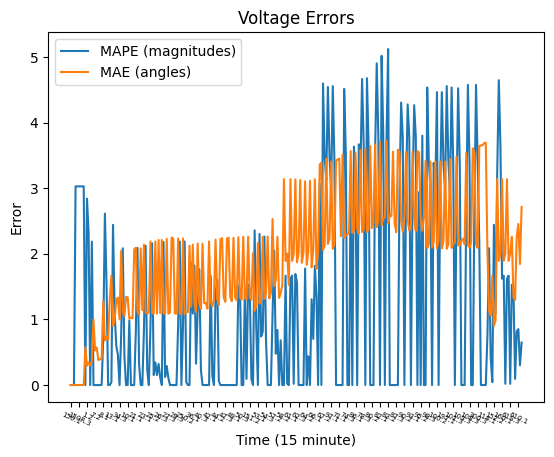

In [44]:
time='07:00'
true = true_voltages.at_time(time)
estimated = estimated_voltages.at_time(time)

err_table = error_table(true, estimated)
plot_errors(err_table).savefig(f"{directory}/errors_morning.png")

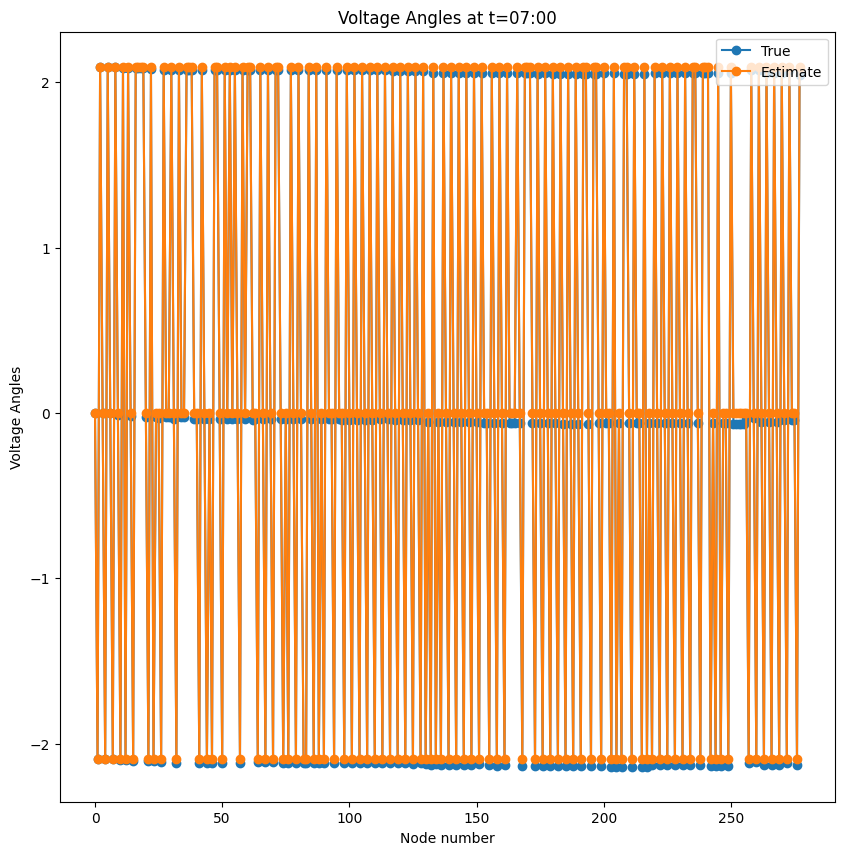

In [45]:
plot_ang(
    true / base_voltages,
    estimated / base_voltages,
    time=time,
    unit="p.u."
).savefig(f"{directory}/angle_morning.png")

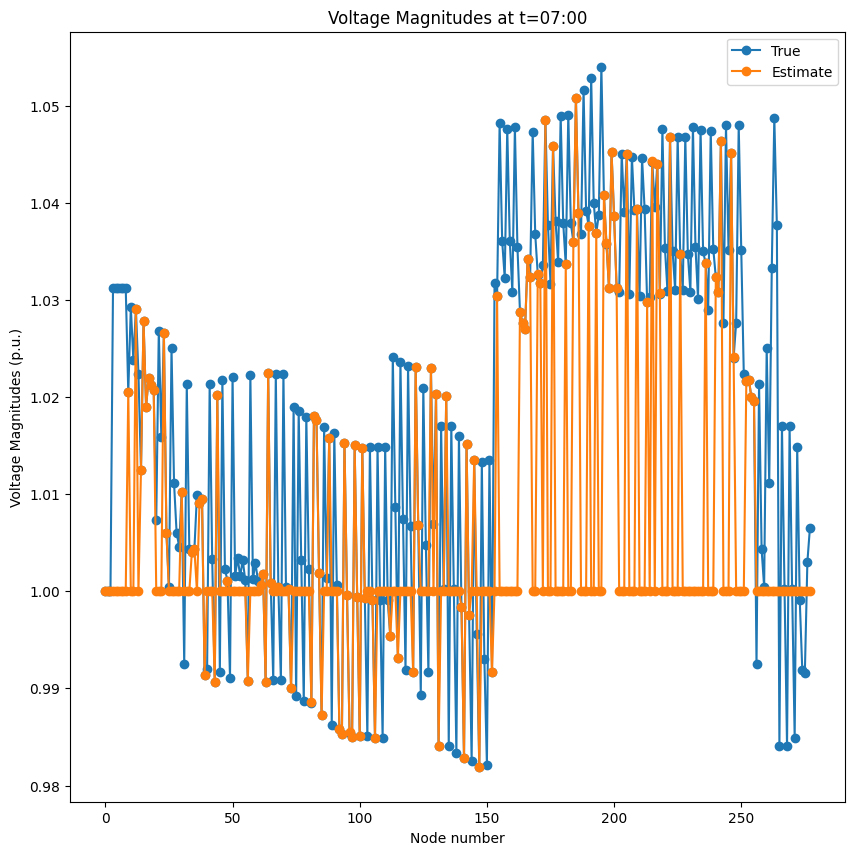

In [46]:
plot_mag(
    true / base_voltages,
    estimated / base_voltages,
    time=time,
    unit="p.u."
).savefig(f"{directory}/mag_morning.png")

In [47]:
### Noon

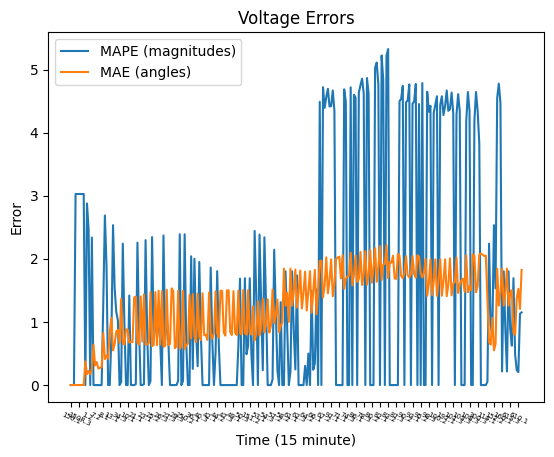

In [48]:
time='12:30'
true = true_voltages.at_time(time)
estimated = estimated_voltages.at_time(time)

err_table = error_table(true, estimated)
plot_errors(err_table).savefig(f"{directory}/errors_noon.png")

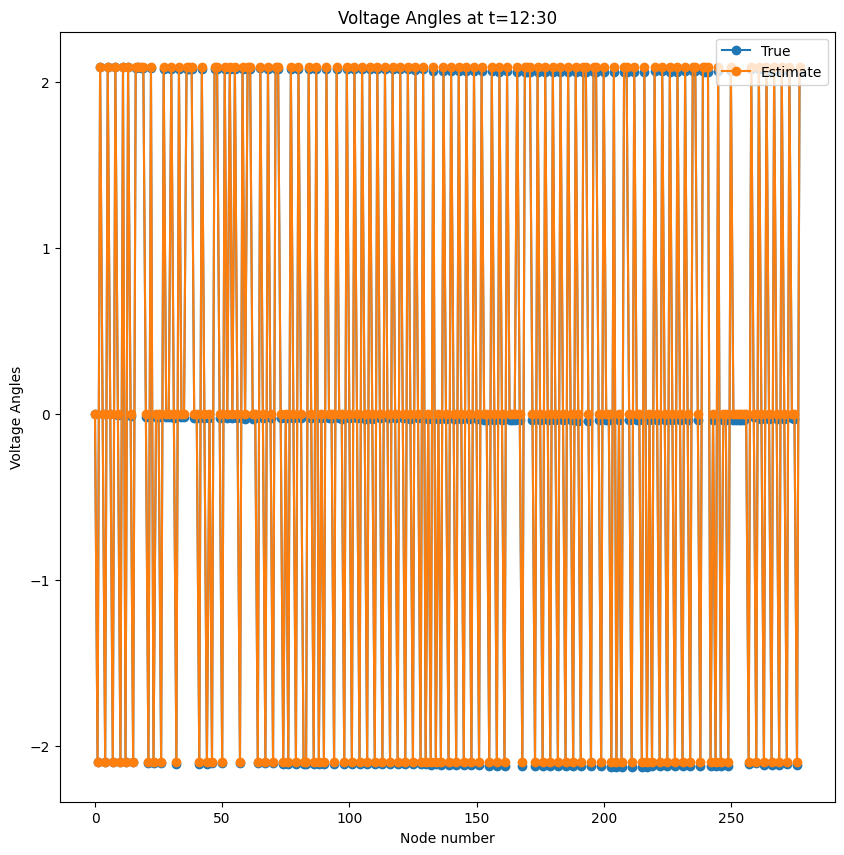

In [49]:
plot_ang(
    true / base_voltages,
    estimated / base_voltages,
    time=time,
    unit="p.u."
).savefig(f"{directory}/angle_noon.png")

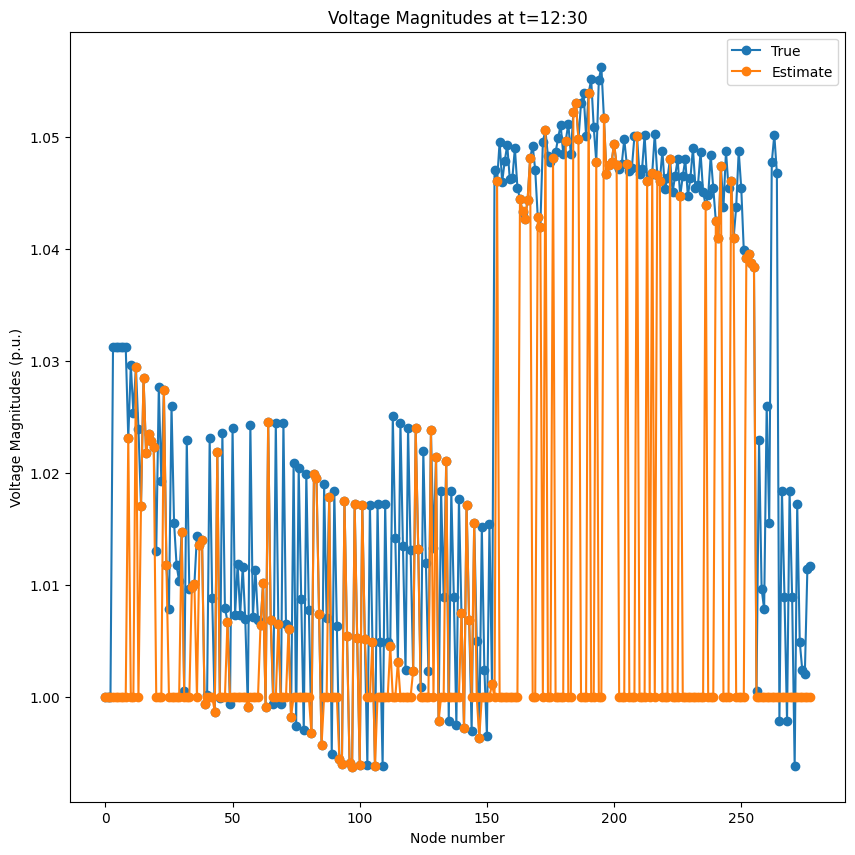

In [50]:
plot_mag(
    true / base_voltages,
    estimated / base_voltages,
    time=time,
    unit="p.u."
).savefig(f"{directory}/mag_noon.png")

### Evening

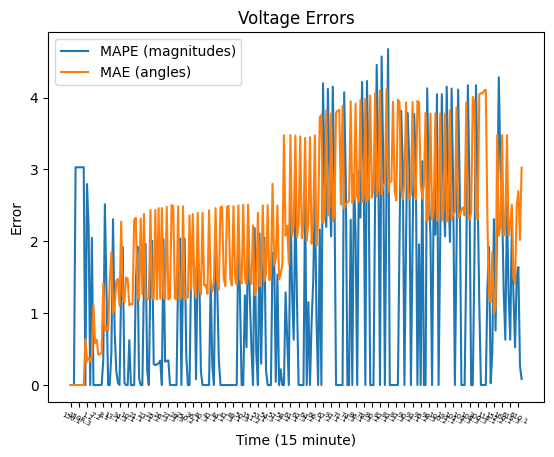

In [54]:
time='17:30'
true = true_voltages.at_time(time)
estimated = estimated_voltages.at_time(time)

err_table = error_table(true, estimated)
plot_errors(err_table).savefig(f"{directory}/errors_evening.png")

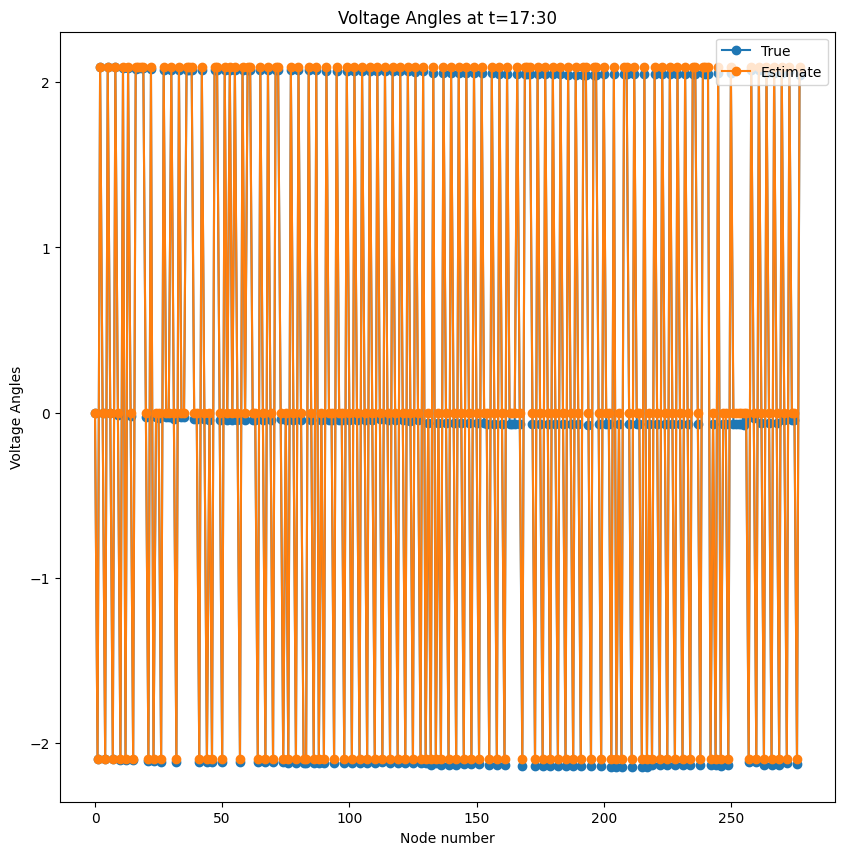

In [55]:
plot_ang(
    true / base_voltages,
    estimated / base_voltages,
    time=time,
    unit="p.u."
).savefig(f"{directory}/angle_evening.png")

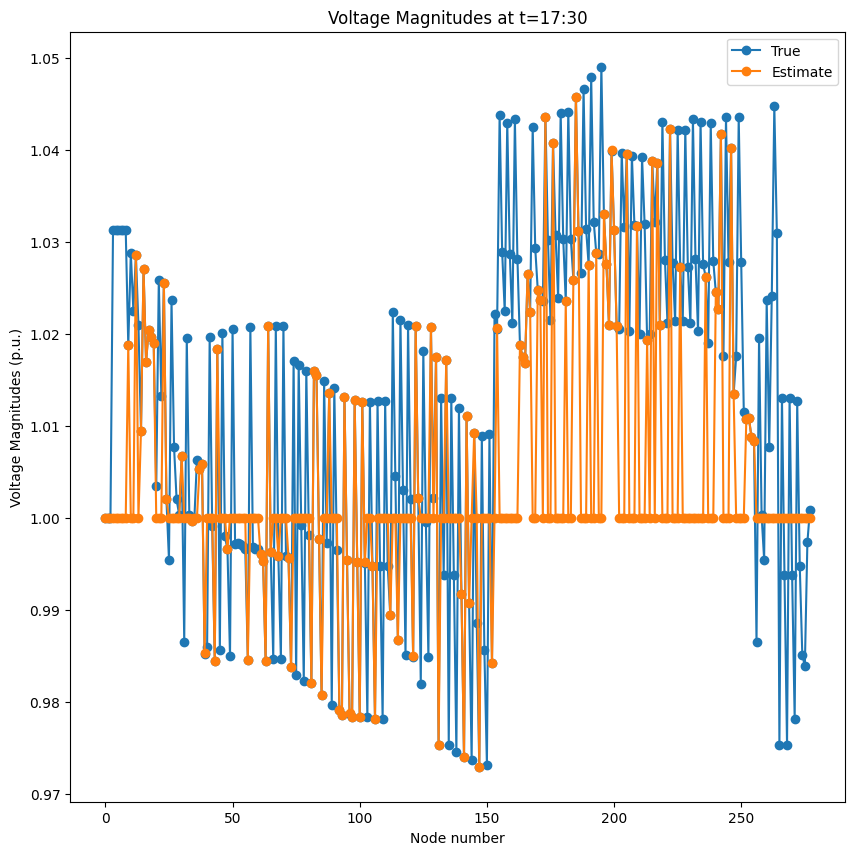

In [56]:
plot_mag(
    true / base_voltages,
    estimated / base_voltages,
    time=time,
    unit="p.u."
).savefig(f"{directory}/mag_evening.png")